In [1]:
setwd("..")

In [2]:
source("Source/functions.R")
library("data.table")
library("ggplot2")

In [3]:
chrmbases_properties <- fread("Report/artifact/chrmbases_properties.csv.gz")

chrmgenes <- fread("Report/artifact/chrmgenes.csv")
chrmgenes <- rbind(chrmgenes,
    chrmbases_properties[is_in_range == "Y" & is_in_primer == "N" & SNVID == "SNV8", list(symbol = "D-loop", start = min(pos), end = max(pos), strand = "*", nbases_covered = .N)], 
    chrmbases_properties[pos %in% 3843:3844, list(symbol = "intergenic", start = min(pos), end = max(pos), strand = "*", nbases_covered = .N)]
)
chrmgenes[c(6, 10, 16, 19, 21, 22, 23, 25, 27, 28, 32, 33, 35)]

symbol,start,end,strand,nbases_covered
<chr>,<int>,<int>,<chr>,<int>
mt-Nd1,2751,3707,+,118
mt-Nd2,3914,4951,+,0
mt-Co1,5328,6872,+,119
mt-Co2,7013,7696,+,120
mt-Atp8,7766,7969,+,0
mt-Atp6,7927,8607,+,0
mt-Co3,8607,9390,+,138
mt-Nd3,9459,9806,+,31
mt-Nd4l,9877,10173,+,0


In [4]:
chrmgenes_cds <- chrmgenes[c(6, 10, 16, 19, 21, 22, 23, 25, 27, 28, 32, 33, 35), ]
chrmbases_properties[, is_cds := ifelse(sapply(pos, function(p) { any(sapply(1:chrmgenes_cds[,.N], function(x) { b <- chrmgenes_cds[x]; p >= b[, start] & p <= b[, end] })) }), "Y", "N")]
chrmbases_properties[, proteins := sapply(pos, function(p) { x <- sapply(1:chrmgenes_cds[,.N], function(x) { b <- chrmgenes_cds[x]; ifelse(p >= b[, start] & p <= b[, end], b[, symbol], "") }); x <- x[x!=""]; paste0(x, collapse = ",") })]

In [5]:
chrmbases_assayed <- chrmbases_properties[is_in_range == "Y" & is_in_primer == "N"]

Genus level data

In [ ]:
genus_mclust <- fread(file = "Report/genus/clustalo-mm10_rn6_base.csv")
names(genus_mclust)[1] <- "pos"
names(genus_mclust)[2] <- "ref"
setkey(genus_mclust, pos)
genus_mclust_varonly <- subset(genus_mclust, alignment != "*" & ref != "-")
genus_mclust_varonly <- genus_mclust_varonly[, -c("alignment")]
fwrite(genus_mclust_varonly, file = "Report/evo/genus_mclust_varonly.csv")

Species level data

In [ ]:
species_mclust <- fread(file = "Report/species/clustalo-8species_base.csv")
names(species_mclust)[1] <- "pos"
names(species_mclust)[which(names(species_mclust) == "Mus_musculus")] <- "ref"
setkey(species_mclust, pos)
setcolorder(species_mclust, c(1, 9, 2:8, 10))
species_mclust_varonly <- subset(species_mclust, alignment != "*" & ref != "-")
species_mclust_varonly <- species_mclust_varonly[, -c("alignment")]
fwrite(species_mclust_varonly, file = "Report/evo/species_mclust_varonly.csv")

Subspecies (strain) level data

In [ ]:
strains_mclust <- fread(file = "Report/strains/clustalo-17strains_base.csv")
names(strains_mclust)[1] <- "pos"
names(strains_mclust)[which(names(strains_mclust) == "C57BL/6J")] <- "ref"
setkey(strains_mclust, pos)
setcolorder(strains_mclust, c(1, 18, 2:17, 19))
strains_mclust_varonly <- subset(strains_mclust, alignment != "*" & ref != "-")
strains_mclust_varonly <- strains_mclust_varonly[, -c("alignment")]
fwrite(strains_mclust_varonly, file = "Report/evo/strains_mclust_varonly.csv")

Population level data

In [ ]:
castdom_mclust <- fread(file = "Report/population/clustalo-castaneus_domesticus_base.csv")
names(castdom_mclust)[1] <- "pos"
names(castdom_mclust)[which(names(castdom_mclust) == "C57BL/6J")] <- "ref"
setkey(castdom_mclust, pos)
setcolorder(castdom_mclust, c(1, 31, 2:30, 32))
castdom_mclust_varonly <- subset(castdom_mclust, alignment != "*" & ref != "-")
castdom_mclust_varonly <- castdom_mclust_varonly[, -c("alignment")]

X_cast <- data.table(t(castdom_mclust_varonly[, castaneus_TW3:castaneus_KM][, apply(.SD, 1, function(x) table(factor(x, levels = c("A", "C", "G", "T", "-"))))]))
X_dom <- data.table(t(castdom_mclust_varonly[, domesticus_Ker_Gui05:domesticus_HB_4242][, apply(.SD, 1, function(x) table(factor(x, levels = c("A", "C", "G", "T", "-"))))]))
X_castdom <- data.table(X_cast, X_dom)
kcast <- X_castdom[, 1:5][, apply(.SD, 1, function(x) any(x == 9))]
kdom <- X_castdom[, 6:10][, apply(.SD, 1, function(x) any(x == 20))]
castdom_div_pos <- X_castdom[, castdom_mclust_varonly[kcast & kdom, pos]]
castdom_poly_pos <- X_castdom[, castdom_mclust_varonly[xor(kcast, kdom), pos]]

castdom_mclust_varonly[, type := ""]
castdom_mclust_varonly[pos %in% castdom_div_pos, type := "div"]
castdom_mclust_varonly[pos %in% castdom_poly_pos, type := "poly"]
fwrite(castdom_mclust_varonly, file = "Report/evo/population_mclust_varonly.csv")

Ti/Tv in genus, species, strains and population data

Genus level Ti/Tv

In [10]:
everymuts_vep_unique <- fread("Report/SNVs/impact/everymuts_vep_unique.csv.gz")
classes <- c("nonsynonymous", "synonymous", "tRNA", "rRNA", "D-loop", "intergenic")

genus_basediff <- copy(genus_mclust_varonly)
genus_basediff[, alt := toupper(Rattus_norvegicus)]
genus_basediff[, alt := sub('-', "del", alt)]
genus_basediff[, ref := toupper(ref)]
genus_basediff[, mut := paste0(ref, '>', alt)]
genus_basediff[, posmut := paste0(pos, ':', mut)]
genus_basediff <- genus_basediff[!duplicated(posmut)]
genus_basediff <- everymuts_vep_unique[, c("posmut", "class")][genus_basediff, on = "posmut"]
genus_transmuts_byclass <- sapply(classes, function(cl) dcast.data.table(genus_basediff[class == cl, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
genus_titv_byclass <- t(sapply(genus_transmuts_byclass, function(X) Genetics$titv(Tools$dt2df(X))))
genus_transmuts <- dcast.data.table(genus_basediff[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
genus_titv_byclass <- rbind(genus_titv_byclass, Genetics$titv(Tools$dt2df(genus_transmuts)))
rownames(genus_titv_byclass) <- c(classes, "average")
genus_titv_byclass

,ti,tv,r
nonsynonymous,240,318,0.7547170
synonymous,947,658,1.4392097
tRNA,78,59,1.3220339
rRNA,153,137,1.1167883
D-loop,73,136,0.5367647
intergenic,8,8,1.0000000
average,1499,1316,1.1390578


In [ ]:
write.csv(genus_titv_byclass, file = "Report/evo/genus_titv_byclass.csv")

In [12]:
genus_basediff_assayed <- everymuts_vep_unique[, c("posmut", "class")][genus_basediff[pos %in% chrmbases_assayed[, pos]], on = "posmut"]
genus_transmuts_byclass_assayed <- sapply(classes[classes %in% unique(genus_basediff_assayed[, class])], function(cl) dcast.data.table(genus_basediff_assayed[class == cl, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
genus_titv_byclass_assayed <- t(sapply(genus_transmuts_byclass_assayed, function(X) Genetics$titv(Tools$dt2df(X))))
genus_titv_byclass_assayed <- as.data.frame(genus_titv_byclass_assayed)[classes, ]
rownames(genus_titv_byclass_assayed) <- classes
genus_titv_byclass_assayed <- as.matrix(genus_titv_byclass_assayed)
genus_transmuts_assayed <- dcast.data.table(genus_basediff_assayed[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
genus_titv_byclass_assayed <- rbind(genus_titv_byclass_assayed, Genetics$titv(Tools$dt2df(genus_transmuts_assayed)))
rownames(genus_titv_byclass_assayed) <- c(classes, "average")
genus_titv_byclass_assayed

,ti,tv,r
nonsynonymous,22,31,0.7096774
synonymous,82,43,1.9069767
tRNA,11,6,1.8333333
rRNA,14,14,1.0000000
D-loop,12,22,0.5454545
intergenic,NA,NA,NA
average,141,116,1.2155172


In [ ]:
write.csv(genus_titv_byclass_assayed, file = "Report/evo/genus_titv_byclass_assayed.csv")

Species level Ti/Tv

In [14]:
species_basediff <- copy(species_mclust_varonly)
species_basediff <- species_basediff[, apply(.SD, 1, function(x) paste(x[1], ">", x[-1], sep = "")), by = "pos"]
names(species_basediff)[2] <- "mut"
species_basediff[, mut := toupper(mut)]
species_basediff[, mut := sub('-', "del", mut)]
species_basediff[, ref := sapply(strsplit(mut, '>'), '[', 1)]
species_basediff[, alt := sapply(strsplit(mut, '>'), '[', 2)]
species_basediff <- species_basediff[ref != alt]
species_basediff[, posmut := paste0(pos, ':', mut)]
species_basediff <- species_basediff[!duplicated(posmut)]
species_basediff <- everymuts_vep_unique[, c("posmut", "class")][species_basediff, on = "posmut"]
species_transmuts_byclass <- sapply(classes, function(cl) dcast.data.table(species_basediff[class == cl, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
species_titv_byclass <- t(sapply(species_transmuts_byclass, function(X) Genetics$titv(Tools$dt2df(X))))
species_transmuts <- dcast.data.table(species_basediff[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
species_titv_byclass <- rbind(species_titv_byclass, Genetics$titv(Tools$dt2df(species_transmuts)))
rownames(species_titv_byclass) <- c(classes, "average")
species_titv_byclass

,ti,tv,r
nonsynonymous,356,305,1.1672131
synonymous,2372,965,2.4580311
tRNA,122,63,1.9365079
rRNA,273,203,1.3448276
D-loop,148,198,0.7474747
intergenic,11,7,1.5714286
average,3282,1741,1.8851235


In [ ]:
write.csv(species_titv_byclass, file = "Report/evo/species_titv_byclass.csv")

In [16]:
species_basediff_assayed <- everymuts_vep_unique[, c("posmut", "class")][species_basediff[pos %in% chrmbases_assayed[, pos]], on = "posmut"]
species_transmuts_byclass_assayed <- sapply(classes[classes %in% unique(species_basediff_assayed[, class])], function(cl) dcast.data.table(species_basediff_assayed[class == cl, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
species_titv_byclass_assayed <- t(sapply(species_transmuts_byclass_assayed, function(X) Genetics$titv(Tools$dt2df(X))))
species_titv_byclass_assayed <- as.data.frame(species_titv_byclass_assayed)[classes, ]
rownames(species_titv_byclass_assayed) <- classes
species_titv_byclass_assayed <- as.matrix(species_titv_byclass_assayed)
species_transmuts_assayed <- dcast.data.table(species_basediff_assayed[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
species_titv_byclass_assayed <- rbind(species_titv_byclass_assayed, Genetics$titv(Tools$dt2df(species_transmuts_assayed)))
rownames(species_titv_byclass_assayed) <- c(classes, "average")
species_titv_byclass_assayed

,ti,tv,r
nonsynonymous,39,31,1.2580645
synonymous,174,70,2.4857143
tRNA,19,10,1.9000000
rRNA,22,20,1.1000000
D-loop,29,31,0.9354839
intergenic,0,1,0.0000000
average,283,163,1.7361963


In [ ]:
write.csv(species_titv_byclass_assayed, file = "Report/evo/species_titv_byclass_assayed.csv")

Strain level Ti/Tv

In [18]:
strains_basediff <- copy(strains_mclust_varonly)
strains_basediff <- strains_basediff[, apply(.SD, 1, function(x) paste(x[1], ">", x[-1], sep = "")), by = "pos"]
names(strains_basediff)[2] <- "mut"
strains_basediff[, mut := toupper(mut)]
strains_basediff[, mut := sub('-', "del", mut)]
strains_basediff[, ref := sapply(strsplit(mut, '>'), '[', 1)]
strains_basediff[, alt := sapply(strsplit(mut, '>'), '[', 2)]
strains_basediff <- strains_basediff[ref != alt]
strains_basediff[, posmut := paste0(pos, ':', mut)]
strains_basediff <- strains_basediff[!duplicated(posmut)]
strains_basediff <- everymuts_vep_unique[, c("posmut", "class")][strains_basediff, on = "posmut"]
strains_transmuts_byclass <- sapply(classes[classes %in% unique(strains_basediff[, class])], function(cl) dcast.data.table(strains_basediff[class == cl, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
strains_titv_byclass <- t(sapply(strains_transmuts_byclass, function(X) Genetics$titv(Tools$dt2df(X))))
strains_titv_byclass <- as.data.frame(strains_titv_byclass)[classes, ]
rownames(strains_titv_byclass) <- classes
strains_titv_byclass <- as.matrix(strains_titv_byclass)
strains_transmuts <- dcast.data.table(strains_basediff[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
strains_titv_byclass <- rbind(strains_titv_byclass, Genetics$titv(Tools$dt2df(strains_transmuts)))
rownames(strains_titv_byclass) <- c(classes, "average")
strains_titv_byclass

,ti,tv,r
nonsynonymous,100,38,2.631579
synonymous,951,154,6.175325
tRNA,50,15,3.333333
rRNA,85,19,4.473684
D-loop,57,41,1.390244
intergenic,5,2,2.500000
average,1248,269,4.639405


In [ ]:
write.csv(strains_titv_byclass, file = "Report/evo/strains_titv_byclass.csv")

In [20]:
strains_basediff_assayed <- everymuts_vep_unique[, c("posmut", "class")][strains_basediff[pos %in% chrmbases_assayed[, pos]], on = "posmut"]
strains_transmuts_byclass_assayed <- sapply(classes[classes %in% unique(strains_basediff_assayed[, class])], function(cl) dcast.data.table(strains_basediff_assayed[class == cl, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
strains_titv_byclass_assayed <- t(sapply(strains_transmuts_byclass_assayed, function(X) Genetics$titv(Tools$dt2df(X))))
strains_titv_byclass_assayed <- as.data.frame(strains_titv_byclass_assayed)[classes, ]
rownames(strains_titv_byclass_assayed) <- classes
strains_titv_byclass_assayed <- as.matrix(strains_titv_byclass_assayed)
strains_transmuts_assayed <- dcast.data.table(strains_basediff_assayed[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
strains_titv_byclass_assayed <- rbind(strains_titv_byclass_assayed, Genetics$titv(Tools$dt2df(strains_transmuts_assayed)))
rownames(strains_titv_byclass_assayed) <- c(classes, "average")
strains_titv_byclass_assayed

,ti,tv,r
nonsynonymous,14,4,3.5
synonymous,65,10,6.5
tRNA,8,1,8.0
rRNA,11,1,11.0
D-loop,7,5,1.4
intergenic,NA,NA,NA
average,105,21,5.0


In [ ]:
write.csv(strains_titv_byclass_assayed, file = "Report/evo/strains_titv_byclass_assayed.csv")

Population level Ti/Tv

In [22]:
castdom_basediff <- copy(castdom_mclust_varonly)
castdom_basediff <- castdom_basediff[, apply(.SD, 1, function(x) paste(x[1], ">", x[-1], sep = "")), by = "pos"]
names(castdom_basediff)[2] <- "mut"
castdom_basediff[, mut := toupper(mut)]
castdom_basediff[, mut := sub('-', "del", mut)]
castdom_basediff[, ref := sapply(strsplit(mut, '>'), '[', 1)]
castdom_basediff[, alt := sapply(strsplit(mut, '>'), '[', 2)]
castdom_basediff <- castdom_basediff[ref != alt]
castdom_basediff[, posmut := paste0(pos, ':', mut)]
castdom_basediff <- castdom_basediff[!duplicated(posmut)]
castdom_basediff <- everymuts_vep_unique[, c("posmut", "class")][castdom_basediff, on = "posmut"]
castdom_transmuts_byclass <- sapply(classes, function(cl) dcast.data.table(castdom_basediff[class == cl, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
castdom_titv_byclass <- t(sapply(castdom_transmuts_byclass, function(X) Genetics$titv(Tools$dt2df(X))))
castdom_transmuts <- dcast.data.table(castdom_basediff[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
castdom_titv_byclass <- rbind(castdom_titv_byclass, Genetics$titv(Tools$dt2df(castdom_transmuts)))
rownames(castdom_titv_byclass) <- c(classes, "average")
castdom_titv_byclass

,ti,tv,r
nonsynonymous,58,39,1.487179
synonymous,411,41,10.024390
tRNA,37,8,4.625000
rRNA,37,12,3.083333
D-loop,46,25,1.840000
intergenic,4,3,1.333333
average,593,128,4.632812


In [ ]:
write.csv(castdom_titv_byclass, file = "Report/evo/population_titv_byclass.csv")

In [24]:
castdom_basediff_assayed <- everymuts_vep_unique[, c("posmut", "class")][castdom_basediff[pos %in% chrmbases_assayed[, pos]], on = "posmut"]
castdom_transmuts_byclass_assayed <- sapply(classes[classes %in% unique(castdom_basediff_assayed[, class])], function(cl) dcast.data.table(castdom_basediff_assayed[class == cl, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N"), simplify = FALSE)
castdom_titv_byclass_assayed <- t(sapply(castdom_transmuts_byclass_assayed, function(X) Genetics$titv(Tools$dt2df(X))))
castdom_titv_byclass_assayed <- as.data.frame(castdom_titv_byclass_assayed)[classes, ]
rownames(castdom_titv_byclass_assayed) <- classes
castdom_titv_byclass_assayed <- as.matrix(castdom_titv_byclass_assayed)
castdom_transmuts_assayed <- dcast.data.table(castdom_basediff_assayed[, .N, by = c("ref", "alt")], ref ~ alt, value.var = "N")
castdom_titv_byclass_assayed <- rbind(castdom_titv_byclass_assayed, Genetics$titv(Tools$dt2df(castdom_transmuts_assayed)))
rownames(castdom_titv_byclass_assayed) <- c(classes, "average")
castdom_titv_byclass_assayed

,ti,tv,r
nonsynonymous,4,3,1.333333
synonymous,36,2,18.000000
tRNA,3,0,Inf
rRNA,2,0,Inf
D-loop,7,4,1.750000
intergenic,NA,NA,NA
average,52,9,5.777778


In [ ]:
write.csv(castdom_titv_byclass_assayed, file = "Report/evo/population_titv_byclass_assayed.csv")

Ti/Tv summary

Whole mt-genome

In [26]:
genus_titv_byclass_dt <- data.table(data = "genera", class = rownames(genus_titv_byclass), genus_titv_byclass)
species_titv_byclass_dt <- data.table(data = "species", class = rownames(species_titv_byclass), species_titv_byclass)
strains_titv_byclass_dt <- data.table(data = "strains", class = rownames(strains_titv_byclass), strains_titv_byclass)
populations_titv_byclass_dt <- data.table(data = "population", class = rownames(castdom_titv_byclass), castdom_titv_byclass)
evo_titv_byclass <- rbindlist(list(genus_titv_byclass_dt, species_titv_byclass_dt, strains_titv_byclass_dt, populations_titv_byclass_dt))
evo_titv_byclass[, data := factor(data, levels = c("genera", "species", "strains", "population"))]

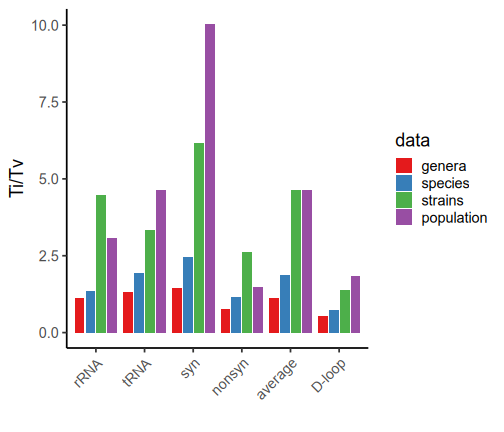

In [27]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
ggplot(evo_titv_byclass[class != "intergenic"], aes(x = class, fill = data, y = r)) + geom_bar(stat = "identity", position = position_dodge2(preserve = "single")) + scale_x_discrete(limits = c("rRNA", "tRNA", "synonymous", "nonsynonymous", "average", "D-loop"), labels = c(rRNA = "rRNA", tRNA = "tRNA", synonymous = "syn", nonsynonymous = "nonsyn", average = "average", "D-loop" = "D-loop")) + theme_classic(base_size = 18) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("Ti/Tv") + scale_fill_brewer(palette = "Set1") + scale_y_continuous()

SMITO covered

In [28]:
genus_titv_byclass_assayed_dt <- data.table(data = "genera", class = rownames(genus_titv_byclass_assayed), genus_titv_byclass_assayed)
species_titv_byclass_assayed_dt <- data.table(data = "species", class = rownames(species_titv_byclass_assayed), species_titv_byclass_assayed)
strains_titv_byclass_assayed_dt <- data.table(data = "strains", class = rownames(strains_titv_byclass_assayed), strains_titv_byclass_assayed)
populations_titv_byclass_assayed_dt <- data.table(data = "population", class = rownames(castdom_titv_byclass_assayed), castdom_titv_byclass_assayed)
evo_titv_byclass_assayed <- rbindlist(list(genus_titv_byclass_assayed_dt, species_titv_byclass_assayed_dt, strains_titv_byclass_assayed_dt, populations_titv_byclass_assayed_dt))
evo_titv_byclass_assayed[, data := factor(data, levels = c("genera", "species", "strains", "population", "SMITO"))]

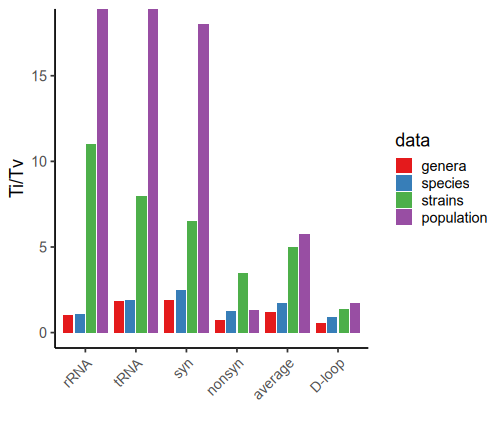

In [29]:
options(repr.plot.width = 7, repr.plot.height = 6, repr.plot.res = 72)
ggplot(evo_titv_byclass_assayed[class != "intergenic"], aes(x = class, fill = data, y = r)) + geom_bar(stat = "identity", position = position_dodge2(preserve = "single")) + scale_x_discrete(limits = c("rRNA", "tRNA", "synonymous", "nonsynonymous", "average", "D-loop"), labels = c(rRNA = "rRNA", tRNA = "tRNA", synonymous = "syn", nonsynonymous = "nonsyn", average = "average", "D-loop" = "D-loop")) + theme_classic(base_size = 18) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + xlab("") + ylab("Ti/Tv") + scale_fill_brewer(palette = "Set1") + scale_y_continuous()

Check the codon table

In [30]:
everymuts_vep <- fread(file = "Report/SNVs/impact/everymuts_vep_unique.csv.gz")
everymuts_vep_synonymous <- everymuts_vep[Feature_type == "Transcript" & Consequence == "synonymous_variant"]
everymuts_vep_nonsynonymous <- everymuts_vep[Feature_type == "Transcript" & Consequence %in% 
    c("frameshift_variant", 
      "frameshift_variant,start_lost", 
      "frameshift_variant,stop_lost", 
      "incomplete_terminal_codon_variant,coding_sequence_variant", 
      "missense_variant", 
      "protein_altering_variant,incomplete_terminal_codon_variant", 
      "start_lost", 
      "stop_gained", 
      "stop_gained,start_lost", 
      "stop_lost", 
      "stop_retained_variant")]
everymuts_vep_synonymous[, class := "synonymous"]
everymuts_vep_nonsynonymous[, class := "nonsynonymous"]
everymuts_vep_cds <- rbind(everymuts_vep_synonymous, everymuts_vep_nonsynonymous)
everymuts_vep_codons <- everymuts_vep_cds[, list(symbol = SYMBOL, codon = sapply(strsplit(Codons, "/"), function(x) toupper(x[1]))), by = c("pos", "STRAND", "CDS_position")]
everymuts_vep_codons[, table(codon)]

codon
 AAA  AAC  AAG  AAT  ACA  ACC  ACG  ACT  AGC  AGT  ATA  ATC  ATG  ATT  CAA  CAC 
1210 1285   24  708 1873 1021   69  697  420  168 2589 1668  344 2791  930  756 
 CAG  CAT  CCA  CCC  CCG  CCT  CGA  CGC  CGG  CGT  CTA  CTC  CTG  CTT  GAA  GAC 
  36  407 1551  405   24  357  411  216   36   96 3177  765  324 1044  951  516 
 GAG  GAT  GCA  GCC  GCG  GCT  GGA  GGC  GGG  GGT  GTA  GTC  GTG  GTT    T  TAA 
 131  361 1152  985   84  564 1308  468  348  420  888  396  132  600   12   76 
 TAC  TAG  TAT  TCA  TCC  TCG  TCT  TGA  TGC  TGG  TGT  TTA  TTC  TTG  TTT 
 720   24  779 1752  564   48  504 1151  205   84  120 1546 1585  178 1298 

In [31]:
everymuts_vep_codons[codon == "T"]

pos,STRAND,CDS_position,symbol,codon
<int>,<int>,<chr>,<chr>,<chr>
9390,1,784,mt-Co3,T
9390,1,784,mt-Co3,T
9390,1,784,mt-Co3,T
9390,1,784,mt-Co3,T
11544,1,1378,mt-Nd4,T
11544,1,1378,mt-Nd4,T
11544,1,1378,mt-Nd4,T
11544,1,1378,mt-Nd4,T
15288,1,1144,mt-Cytb,T


mt-Co3, mt-Nd4, mt-Cytb have the stop codon TAA by polyadenylation. 

In [32]:
everymuts_vep_codons[codon == "T", codon:="TAA"]
everymuts_vep_codons <- unique(everymuts_vep_codons)
everymuts_vep_codons[, strand := ifelse(STRAND == 1, "+", ifelse(STRAND == -1, "-", ""))]
everymuts_vep_codons[, STRAND := NULL]

MK test on the population data

In [33]:
vertmtcodon <- fread(file = "Report/evo/vertmtcodon.csv")

castdom_mclust_varonly <- vertmtcodon[castdom_mclust_varonly, on = "pos"]
setcolorder(castdom_mclust_varonly, c(8:42, 1:7))

castdom_mclust_varonly[, CDS_position:= as.integer(CDS_position)]
castdom_mclust_varonly[, codon_index := round((CDS_position+1)/3)]

setcolorder(castdom_mclust_varonly, c(1:2, 43, 3:42))
head(castdom_mclust_varonly)

pos,CDS_position,codon_index,symbol,strand,ref,castaneus_TW3,castaneus_PX,castaneus_CAST/EiJ,castaneus_TW2,⋯,domesticus_BG_4235,domesticus_HB_4242,type,Codon,AA,S,N,Pos1,Pos2,Pos3
<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
51,NA,NA,NA,NA,A,-,A,A,-,⋯,A,A,poly,NA,NA,NA,NA,NA,NA,NA
55,NA,NA,NA,NA,G,T,T,T,T,⋯,A,T,poly,NA,NA,NA,NA,NA,NA,NA
131,NA,NA,NA,NA,G,A,G,G,A,⋯,G,G,poly,NA,NA,NA,NA,NA,NA,NA
165,NA,NA,NA,NA,A,C,C,C,C,⋯,A,A,div,NA,NA,NA,NA,NA,NA,NA
201,NA,NA,NA,NA,T,C,T,T,C,⋯,T,T,poly,NA,NA,NA,NA,NA,NA,NA
233,NA,NA,NA,NA,A,A,A,A,A,⋯,A,T,poly,NA,NA,NA,NA,NA,NA,NA


In [ ]:
fwrite(castdom_mclust_varonly, file = "Report/evo/population_mclust_varonly.csv")

In [35]:
castdom_mclust_varonly_ns_percodon <- castdom_mclust_varonly[!is.na(symbol) & type != ""][, list(sites = paste0(unique(pos), collapse = ","), types = paste0(unique(type), collapse = ","), AA = unique(AA), syn = mean(S), nonsyn = mean(N)), by = c("symbol", "strand", "codon_index")]
head(castdom_mclust_varonly_ns_percodon)

symbol,strand,codon_index,sites,types,AA,syn,nonsyn
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
mt-Nd1,+,6,2766,poly,I,0.3333333,2.666667
mt-Nd1,+,11,2781,poly,V,1.0000000,2.000000
mt-Nd1,+,12,2786,div,P,1.0000000,2.000000
mt-Nd1,+,30,2839,poly,Y,1.0000000,2.000000
mt-Nd1,+,39,2865,poly,I,0.3333333,2.666667
mt-Nd1,+,40,2870,div,V,1.0000000,2.000000


In [ ]:
fwrite(castdom_mclust_varonly_ns_percodon, file = "Report/evo/population_mclust_varonly_ns_percodon.csv")

In [37]:
castdom_mclust_varonly_ns_pergene <- castdom_mclust_varonly_ns_percodon[types %in% c("div", "poly")][, list(S = sum(syn), N = sum(nonsyn)), keyby = c("symbol", "types")]
head(castdom_mclust_varonly_ns_pergene)

symbol,types,S,N
<chr>,<chr>,<dbl>,<dbl>
mt-Atp6,div,5.666667,15.333333
mt-Atp6,poly,15.666667,44.333333
mt-Atp8,div,1.333333,1.666667
mt-Atp8,poly,2.666667,6.333333
mt-Co1,div,12.000000,33.000000
mt-Co1,poly,31.333333,91.666667


In [ ]:
fwrite(castdom_mclust_varonly_ns_pergene, file = "Report/evo/population_mclust_varonly_ns_pergene.csv")

In [39]:
K <- data.table(expand.grid(symbol = castdom_mclust_varonly_ns_pergene[, unique(symbol)], types = c("div", "poly"), stringsAsFactors = FALSE))[order(symbol, types)]
castdom_mclust_varonly_ns_pergene <- castdom_mclust_varonly_ns_pergene[K, on = c("symbol", "types")]
castdom_mclust_varonly_ns_pergene[is.na(S), S:=0]
castdom_mclust_varonly_ns_pergene[is.na(N), N:=0]
castdom_mclust_varonly_mkpval_pergene <- castdom_mclust_varonly_ns_pergene[, list(p = chisq.test(matrix(unlist(.SD), ncol = 2))$p.value), by = c("symbol"), .SDcols = c("S", "N")]
castdom_mclust_varonly_mkpval_pergene

Warning message in chisq.test(matrix(unlist(.SD), ncol = 2)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(matrix(unlist(.SD), ncol = 2)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(matrix(unlist(.SD), ncol = 2)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(matrix(unlist(.SD), ncol = 2)):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(matrix(unlist(.SD), ncol = 2)):
“Chi-squared approximation may be incorrect”


symbol,p
<chr>,<dbl>
mt-Atp6,1.0000000
mt-Atp8,1.0000000
mt-Co1,1.0000000
mt-Co2,0.8245945
mt-Co3,0.4668543
mt-Cytb,0.8562873
mt-Nd1,0.7864418
mt-Nd2,0.9991129
mt-Nd3,1.0000000


In [ ]:
fwrite(castdom_mclust_varonly_mkpval_pergene, file = "Report/evo/population_mclust_varonly_mkpval_pergene.csv")

In [41]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.5.1     data.table_1.16.2

loaded via a namespace (and not attached):
 [1] crayon_1.5.3       vctrs_0.6.5        cli_3.6.3          rlang_1.1.4       
 [5] gene